<a href="https://colab.research.google.com/github/rickqiu/deep-learning/blob/master/tensorflow2_mobilenets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow2 - MobileNets: A Pre-trained Multiclass Classifier

MobileNets are lightweight deep neural networks that are suitable for mobile and embedded vision applications (Howard et al., 2017). Computer Vision (CV) engineers often utilize transfer learning techniques to perform CV tasks with pre-trained convolutional neural networks (CNN). 

Keras Fashion-MNIST is a toy dataset which consists of images of clothing. The data has a training set of 60,000 28x28 grayscale images of 10 fashion categories, along with a testing set of 10,000 images. A dictionary key is defined below with the corresponding class name for each of the integer encoded values in y_train and y_test.

In [0]:
key = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat", 5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input,Reshape,Dense,Dropout,Lambda,GlobalAveragePooling2D,Activation,BatchNormalization
from tensorflow.keras.models import load_model,Model

## Data preprocessing

In [3]:
# Load data sets
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [0]:
# Set the input image dimension
height,width = 56,56

# Resize the image size to (56, 56)
X_train = X_train.reshape((-1, 28, 28))
X_train = np.array([cv2.resize(x, dsize=(height, width)).astype(float) for x in iter(X_train)])
X_train = X_train.reshape((X_train.shape[0], height, width, 1))

X_test = X_test.reshape((-1,28,28))
X_test = np.array([cv2.resize(x, dsize=(height, width)).astype(float) for x in iter(X_test)])
X_test = X_test.reshape((X_test.shape[0], height, width, 1))

In [0]:
# One-hot encoding on y
y_binary_train = tf.one_hot(y_train,10)
y_binary_test = tf.one_hot(y_test,10)

In [0]:
# Define Image Data Generator for training set
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   shear_range=0.1,
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

# Define Image Generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)

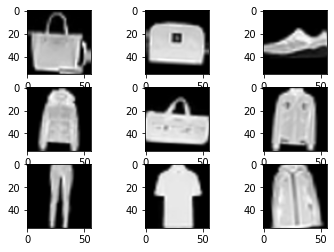

In [7]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in train_datagen.flow(X_train, y_binary_train, batch_size=9, seed=42):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(56, 56), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break	

## Modelling

In [0]:
# Define mobile networks
def mobile_net(height, width):
  
  # Define Input layer
  input_image = Input(shape=(height, width, 1))
  
  # Add a Reshape layer
  input_image1 = Reshape((height, width), input_shape=(height, width, 1))(input_image)
  
  # Add Lambda layer to expand the image channel to 3
  input_image_ = Lambda(lambda x: tf.keras.backend.repeat_elements(tf.keras.backend.expand_dims(x,3),3,3))(input_image1)
  
  # Create a base model from MobileNet with pre-trained weights
  base_model = MobileNet(input_tensor=input_image_, weights='imagenet', include_top=False)

  # Add a avg pooling layer
  x = GlobalAveragePooling2D()(base_model.output)

  # Add a fully connected layer
  x = Dense(1000)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.5)(x)
  
  # Add output layer
  output = Dense(10, activation='softmax')(x)

  model = Model(inputs=input_image, outputs=output)
  return model

In [9]:
# Instantiate a model
model = mobile_net(height, width)
# Show model summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 56, 56)            0         
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 57, 57, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 28, 28, 32)        128       
______________________________________________________________

## Model training

In [10]:
# Train the model
opt=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_datagen.flow(X_train, y_binary_train, batch_size=32, seed=42), 
                    validation_data=test_datagen.flow(X_test, y_binary_test, batch_size=32, seed=42),
                    epochs = 20)

# Save the trained model
model.save('mobile_net.h5')

Epoch 1/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4899 - accuracy: 0.8380 - val_loss: 0.3089 - val_accuracy: 0.8834
Epoch 2/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3296 - accuracy: 0.8862 - val_loss: 0.2511 - val_accuracy: 0.9126
Epoch 3/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3069 - accuracy: 0.8980 - val_loss: 0.2615 - val_accuracy: 0.9083
Epoch 4/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2615 - accuracy: 0.9116 - val_loss: 0.2757 - val_accuracy: 0.9015
Epoch 5/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2494 - accuracy: 0.9142 - val_loss: 0.2015 - val_accuracy: 0.9323
Epoch 6/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2220 - accuracy: 0.9244 - val_loss: 0.2138 - val_accuracy: 0.9259
Epoch 7/20
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2089 - accuracy: 0.9291 - val_loss: 0.1942 -

In [0]:
# Plot learning curves
def plot_learning_curves(history):
    plt.plot(history.history["accuracy"],label="Train Accuracy")
    plt.plot(history.history["val_accuracy"],label="Val Accuracy")
    plt.plot(history.history["loss"],label="Train Loss")
    plt.plot(history.history["val_loss"],label="Val Loss")
    plt.legend()
    plt.show()

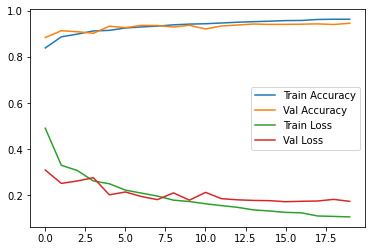

In [12]:
plot_learning_curves(history)